## Dynamic Traffic Assignments: DUO, DUE, DSO


There are 3 famous route choice principles for dynamic traffic assignments (DTA) (the definition varies depending on the terminology).

- Dynamic User Optimal (DUO): Travelers choose the shortest path based on the instantaneous travel time (the current average speed). 
- Dynamic User Equilibrium (DUE): Travelers choose the shortest path based on the actual travel time. 
- Dynamic System Optimal (DSO): Travelers choose the path so that the total travel time is minimized.

The important point of DTA is that travel time may change as the time progresses. 
Therefore, in the DUO, the chosen route may turn out not to be the actual shortest path after the traveler completes their trip, as the travel time may change during their trip.
Similarly, in the DUE, the "actual travel time" is unknown when the traveler choose the route, as it depends on the future travel time.
Likewise, in the DSO, it is not obvious which path minimizes the total travel time.

The default routing principle of UXsim is based on DUO, because it is reasonable and very easy to compute.

DUE and DSO are also important as theoretical benchmarks. 
Due to the aforementioned complexity, it is known that they are difficult to solve especially when the network is large. 
But, for small or mid scale networks with relatively small number of platoons, their approximate solutions can be obtained by UXsim. 
The solvers for DTA problems are implemented as `uxsim.DTAsolvers` submodule.
In this notebook, we demonstrate their behaviors.


In [1]:
%matplotlib inline
from pylab import *
import uxsim
from uxsim.DTAsolvers import *

### Two route network with parallel highway and arterial

Highway: fast but small capacity

Arterial: slow but large capacity

World definition by function

In [2]:

# scenario definition
def create_World():
    """
    A function that returns World object with scenario informaiton. This is faster way to reuse the same scenario, as `World.copy` or `World.load_scenario` takes some computation time.
    """
    W = uxsim.World(
        name="",
        deltan=20,
        tmax=6000,
        print_mode=0, save_mode=1, show_mode=1,
        vehicle_logging_timestep_interval=1, 
        hard_deterministic_mode=False,
        random_seed=42
    )

    W.addNode("1", 0, 1)
    W.addNode("2", 1, 1)
    W.addNode("3", 5, 1)
    W.addNode("4", 0, 0)
    W.addNode("5", 1, 0)
    W.addNode("6", 5, 0)
    W.addNode("7", 6, 0.5)

    W.addLink("highway12", "1", "2", length=1000, number_of_lanes=1, merge_priority=1)
    W.addLink("highway23", "2", "3", length=3000, number_of_lanes=1, merge_priority=1, capacity_out=0.6)
    W.addLink("highway37", "3", "7", length=1000, number_of_lanes=1, merge_priority=1)
    W.addLink("onramp", "5", "2", length=1000, number_of_lanes=1, merge_priority=0.5)
    W.addLink("arterial45", "4", "5", length=1000, free_flow_speed=10, number_of_lanes=2, merge_priority=0.5)
    W.addLink("arterial56", "5", "6", length=3000, free_flow_speed=10, number_of_lanes=2, merge_priority=0.5)
    W.addLink("arterial67", "6", "7", length=1000, free_flow_speed=10, number_of_lanes=2, merge_priority=0.5)

    W.adddemand("1", "7", 0, 3000, 0.3)
    W.adddemand("4", "7", 0, 3000, 0.4*3)

    return W

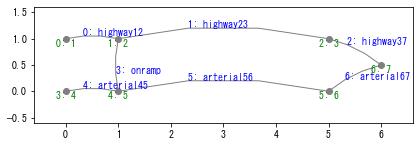

In [4]:
W = create_World()
W.show_network()

In [6]:
def visualizaion_helper_function(W):
    W.analyzer.print_simple_stats(force_print=True)
    W.analyzer.network_average()

    r1 = W.defRoute(["arterial45", "onramp", "highway23", "highway37"])
    r2 = W.defRoute(["arterial45", "arterial56", "arterial67"])

    W.analyzer.time_space_diagram_traj_links(r1.links)
    W.analyzer.time_space_diagram_traj_links(r2.links)

    ttt = np.linspace(0, W.TIME, W.TSIZE)
    tt1 = [r1.actual_travel_time(t) for t in ttt]
    tt2 = [r2.actual_travel_time(t) for t in ttt]

    fig, ax1 = subplots()
    ax1.plot(ttt, tt1, "--", label="r1", lw=1)
    ax1.plot(ttt, tt2, "--", label="r2", lw=1)
    ax1.set_xlabel("t")
    ax1.set_ylabel("travel time")
    ax1.grid()
    ax2 = ax1.twinx()
    ax2.set_ylabel("cumlative count")
    ax2.plot(ttt, W.get_link("onramp").cum_arrival, "-", label="highway (r1)")
    ax2.plot(ttt, W.get_link("arterial56").cum_arrival, "-", label="arterial (r2)")
    ax1.legend(loc="upper center", bbox_to_anchor=(0.1, 1.25), ncol=1)
    ax2.legend(loc="upper center", bbox_to_anchor=(0.9, 1.25), ncol=1)
    show()

results:
 average speed:	 9.2 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 897.6 s
 average delay of trips:	 567.6 s
 delay ratio:			 0.632
 total distance traveled:	 23580000.0 m
results:
 average speed:	 9.2 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 897.6 s
 average delay of trips:	 567.6 s
 delay ratio:			 0.632
 total distance traveled:	 23580000.0 m


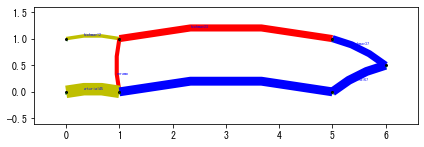

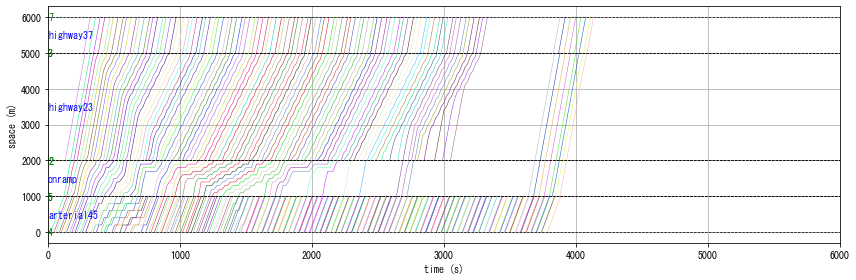

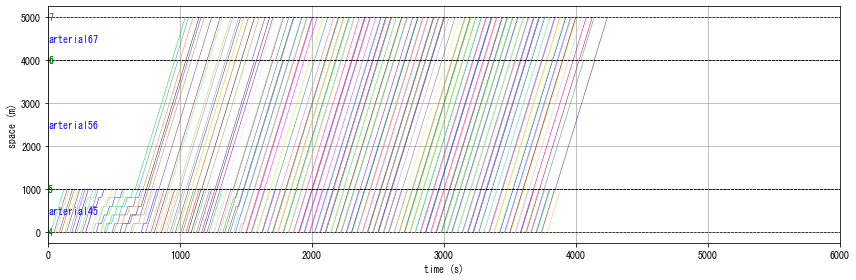

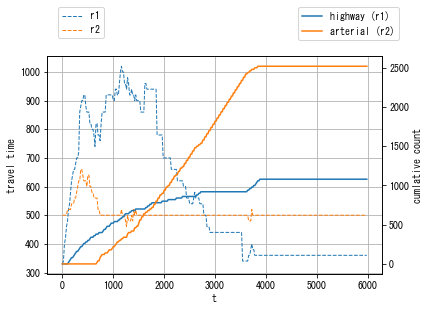

In [11]:
# DUO (default)

W_DUO = create_World()
W_DUO.exec_simulation()
W_DUO.analyzer.print_simple_stats(force_print=True)
df_DUO = W.analyzer.basic_to_pandas()

visualizaion_helper_function(W_DUO)

simulation setting (not finalized):
 scenario name: 
 simulation duration:	 6000 s
 number of vehicles:	 4500 veh
 total road length:	 11000 m
 time discret. width:	 20 s
 platoon size:		 20 veh
 number of timesteps:	 300.0
 number of platoons:	 225
 number of links:	 7
 number of nodes:	 7
 setup time:		 0.00 s
number of OD pairs: 23, number of routes: 25
solving DUE...
 iter 0: time gap: 13080.0, potential route change: 79, route change: 3, total travel time:  4039200.0, delay ratio:  0.632
 iter 1: time gap: 15400.0, potential route change: 81, route change: 6, total travel time:  3814000.0, delay ratio:  0.611
 iter 2: time gap: 13440.0, potential route change: 76, route change: 10, total travel time:  3773200.0, delay ratio:  0.606
 iter 3: time gap: 10560.0, potential route change: 76, route change: 6, total travel time:  3293200.0, delay ratio:  0.549
 iter 4: time gap: 9780.0, potential route change: 85, route change: 4, total travel time:  3195600.0, delay ratio:  0.535
 iter 

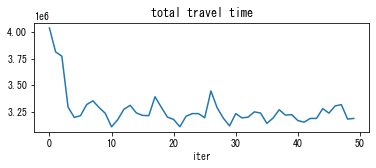

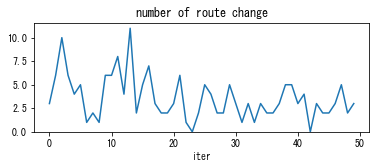

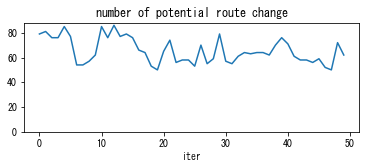

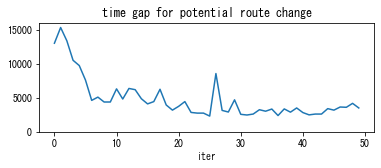

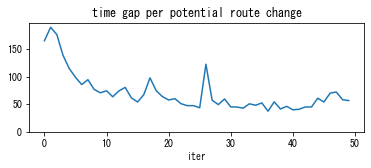

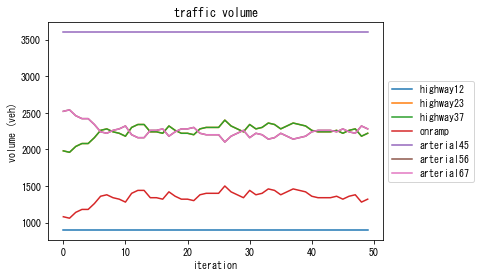

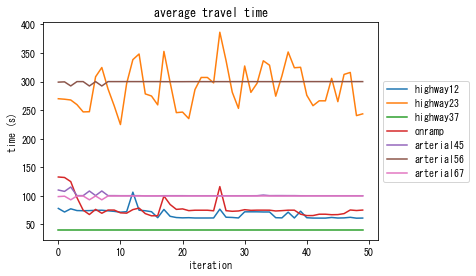

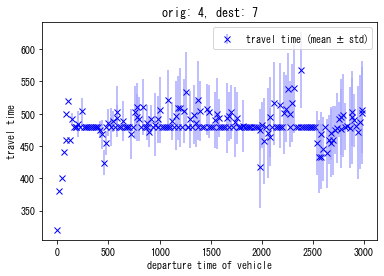

results:
 average speed:	 10.8 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 708.0 s
 average delay of trips:	 378.0 s
 delay ratio:			 0.534
 total distance traveled:	 23820000.0 m


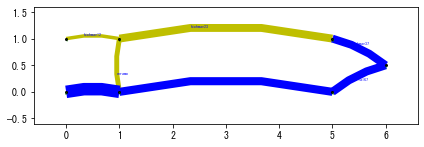

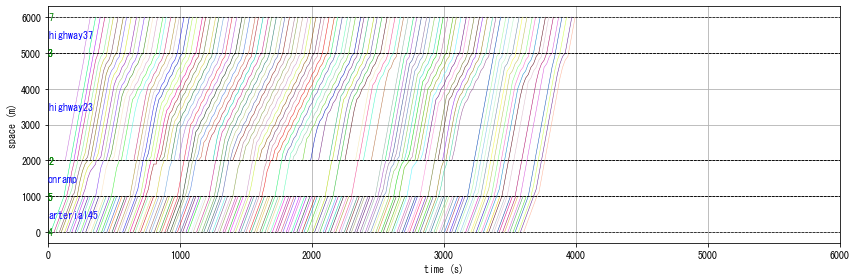

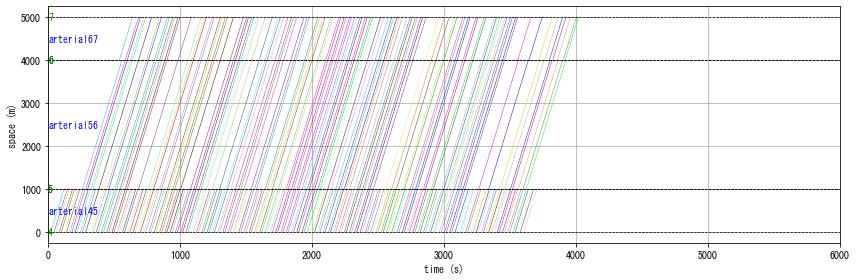

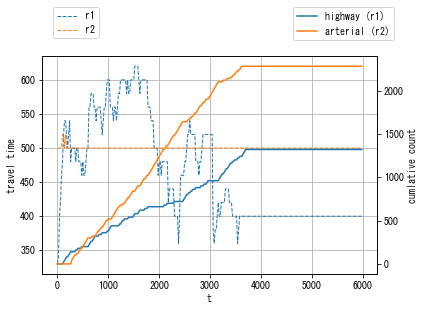

In [12]:
# DUE
solver_DUE = SolverDUE(create_World)
solver_DUE.solve(max_iter=50)
W_DUE = solver_DUE.W_sol
W_DUE.analyzer.print_simple_stats(force_print=True)
df_DUE = W_DUE.analyzer.basic_to_pandas()

solver_DUE.plot_convergence()
solver_DUE.plot_link_stats()
solver_DUE.plot_vehicle_stats(orig="4", dest="7")

visualizaion_helper_function(W_DUE)

simulation setting (not finalized):
 scenario name: 
 simulation duration:	 6000 s
 number of vehicles:	 4500 veh
 total road length:	 11000 m
 time discret. width:	 20 s
 platoon size:		 20 veh
 number of timesteps:	 300.0
 number of platoons:	 225
 number of links:	 7
 number of nodes:	 7
 setup time:		 0.00 s
number of OD pairs: 23, number of routes: 25
solving DSO...
 using pre-solved World...
iter 0, ttt:3186000.0
iter 1, ttt:3165200.0
iter 2, ttt:3165200.0
iter 3, ttt:3165200.0
iter 4, ttt:3144000.0
iter 5, ttt:3138000.0
iter 6, ttt:3138000.0
iter 7, ttt:3138000.0
iter 8, ttt:3138000.0
iter 9, ttt:3138000.0
iter 10, ttt:3138000.0
iter 11, ttt:3138000.0
iter 12, ttt:3138000.0
iter 13, ttt:3138000.0
iter 14, ttt:3138000.0
iter 15, ttt:3139600.0
iter 16, ttt:3139600.0
iter 17, ttt:3114400.0
iter 18, ttt:3113200.0
iter 19, ttt:3112000.0
iter 20, ttt:3077600.0
iter 21, ttt:3033200.0
iter 22, ttt:3005600.0
iter 23, ttt:2999600.0
iter 24, ttt:2999600.0
iter 25, ttt:2999600.0
iter 26, tt

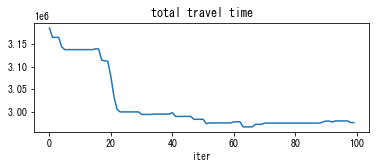

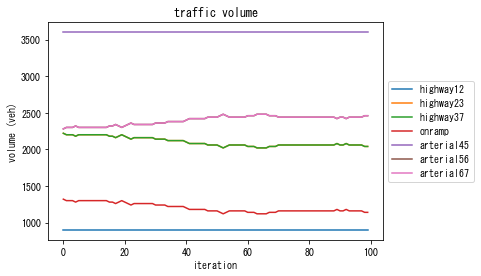

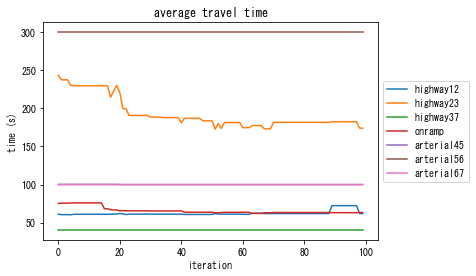

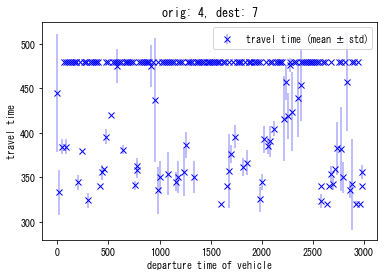

results:
 average speed:	 11.9 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 661.3 s
 average delay of trips:	 331.3 s
 delay ratio:			 0.501
 total distance traveled:	 23640000.0 m


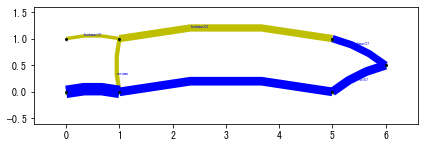

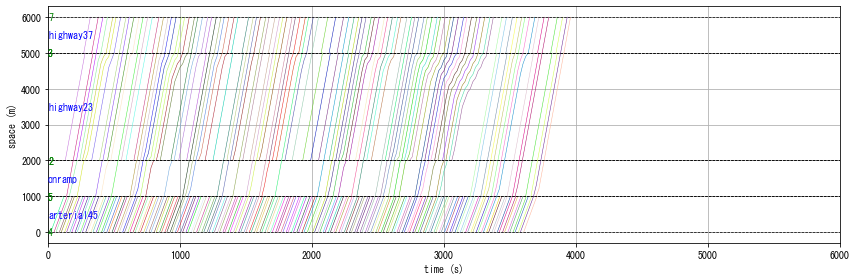

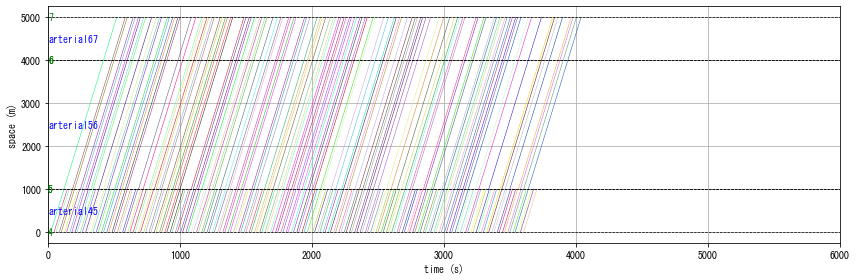

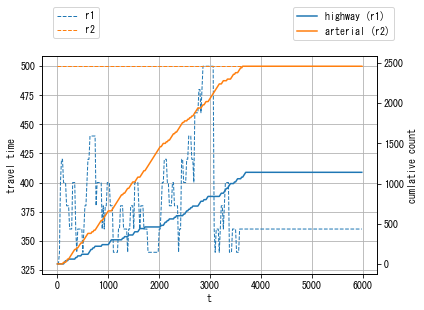

In [15]:
# DSO
solver_DSO = SolverDSO(create_World)
solver_DSO.solve(max_iter=100, initial_solution_World=W_DUE)
W_DSO = solver_DSO.W_sol
W_DSO.analyzer.print_simple_stats(force_print=True)
df_DSO = W_DSO.analyzer.basic_to_pandas()

solver_DSO.plot_convergence()
solver_DSO.plot_link_stats()
solver_DSO.plot_vehicle_stats(orig="4", dest="7")

visualizaion_helper_function(W_DSO)

################################################################################
Deriving DUO
   total_trips  completed_trips  total_travel_time  average_travel_time  \
0         4500             4500          4039200.0                897.6   

   total_delay  average_delay  
0    2554200.0          567.6  
solving DSO by GA...
Generation 0
 total travel times: 4022400.0 3626000.0 3980800.0 4223600.0 3876400.0 3299200.0 3956000.0 4188400.0000000005 3702800.0 3810400.0 4514800.0 5365200.0 4569600.0 5751200.0 4844400.0 4836000.0 4770400.0 4350400.0 3478400.0 5160400.0 
 Best fitness = -3299200.0, TTT = 3299200.0, completed trips: 4500
Generation 1
 total travel times: 3299200.0 3478400.0 3846000.0 3918000.0 3478400.0 3478400.0 3564800.0 3387600.0 3805600.0 3464400.0 3626000.0 3296800.0 3444800.0 4008400.0 3646000.0 3586000.0 3478400.0 3626000.0 3977200.0 3624400.0 
 Best fitness = -3296800.0, TTT = 3296800.0, completed trips: 4500
Generation 2
 total travel times: 3296800.0 3299200.0 334

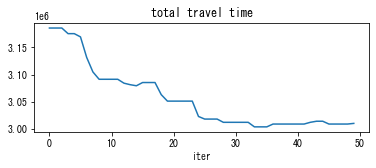

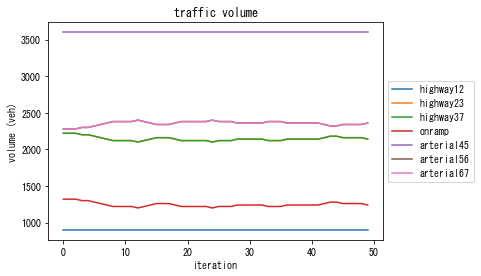

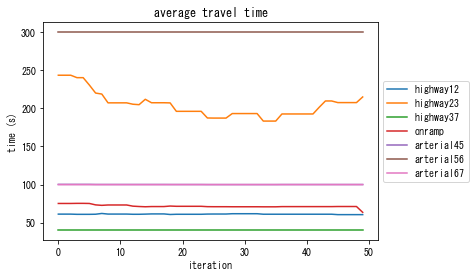

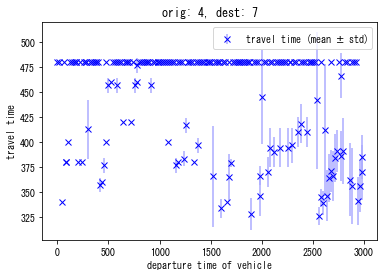

results:
 average speed:	 12.0 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 654.6 s
 average delay of trips:	 324.6 s
 delay ratio:			 0.496
 total distance traveled:	 23600000.0 m


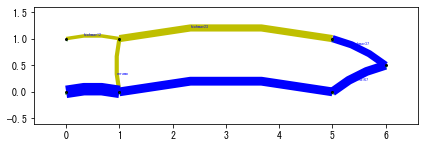

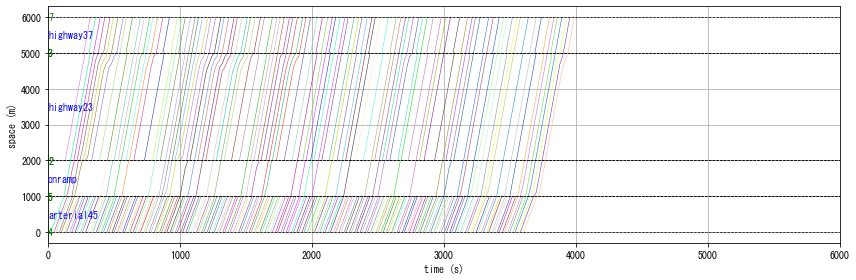

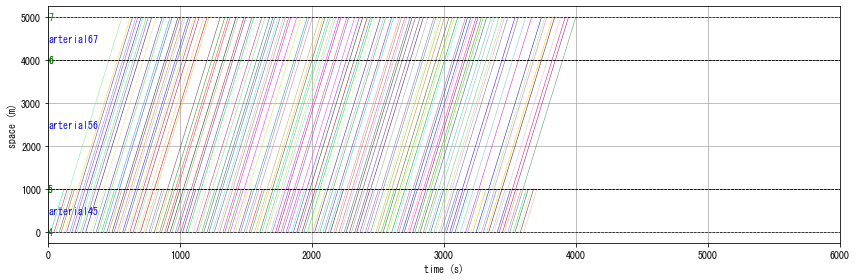

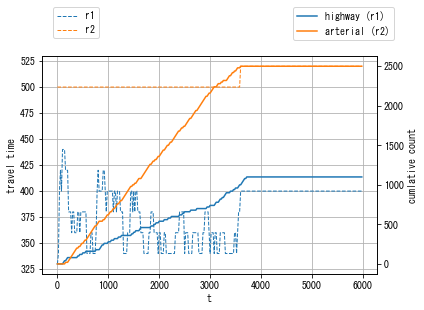

In [14]:
# DSO by GA
solver_DSO_GA = SolverDSO_GA(create_World)
solver_DSO_GA.solve(max_iter=50, pop_size=20)
W_DSO_GA = solver_DSO_GA.W_sol
W_DSO_GA.analyzer.print_simple_stats(force_print=True)
df_DSO_GA = W_DSO_GA.analyzer.basic_to_pandas()

solver_DSO.plot_convergence()
solver_DSO.plot_link_stats()
solver_DSO.plot_vehicle_stats(orig="4", dest="7")

visualizaion_helper_function(W_DSO_GA)

### SF network